# Multi-Asset TOB Example

In this example we showcase a simple pairs trading strategy on one exchange. 

The strategy is based on the co-movement of two assets, UNI & SUSHI, and is heavily inspired by [this](https://github.com/jamesmawm/High-Frequency-Trading-Model-with-IB/blob/master/models/hft_model_1.py) model from James Ma. 

For it, we need two measures: 
- beta: $\beta = \frac{\mu_{SUSHI}}{\mu_{UNI}}$ where $\mu$ is the rolling average of the mid-price of an asset. The calculation used here is the one-pass EMA with a decay of 100. This beta between the two means is used to infer the mid-price of the SUSHI based on UNI. So $\overline{\text{SUSHI}} = \text{UNI} \times \beta$ where we have a trading decision.
- vol_ratio: $\gamma = \frac{\sigma_{r_{SUSHI}}}{\sigma_{r_{UNI}}}$ where $r_{symbol}$ is the percentage return of an asset and the ratio compares the intensity of the market at a given time. If the ratio is above 1 it means that here, SUSHI is experiencing more volatility than UNI. This can be interpreted as the market being trending.

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange
from src.utils.one_pass_calculations import mean, var

%load_ext autoreload 
%autoreload 2

## Import data

Importing the data and getting it ready to load into the exchange. The data can be aquired using the example in the dataloader [here](https://github.com/jaNGOB/pySimX/blob/main/pySimX/examples/data_loader/tardis_example.py).

In [2]:
folder_path = 'data_loader/datasets/'

In [3]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)
    return df

In [4]:
symbols = ['SUSHIUSDT', 'UNIUSDT']

trades_list = []
quotes_list = []

for symbol in symbols: 
    # define folder path
    quotes_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'quotes']
    
    trades_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'trades']

In [5]:
quotes = get_data(quotes_list)
trades = get_data(trades_list)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


## Strategy Example

Our implementation of the mean and standard deviation uses one-pass algorithms. These algorithms are designed to update statistical measures by considering only the most recent data point in conjunction with the previously calculated values. This approach, also known as the one-pass method, allows each data point to be processed just once.
The mean is done by the following formula:
$$\mu_t = w_t X_t + (1-w_t) * \mu_{t-1}$$
Where: 
- $X_t$ is the price of an asset at time $t$
- $w_t$ is the weight at time $t$, which is determined based on a predefined lookback period. 
The weight $w_t$ is calculated as the minimum value between $\frac{\text{ts}_t - \text{ts}_{t-1}}{\text{lookback}}$ and 1. Here, the lookback period is a fixed duration (specified in nanoseconds in this case) that sets the maximum possible weight (1) for a data point. If an update arrives before the lookback period has elapsed, the corresponding data point is weighted according to the time elapsed since the last update.

In [6]:
lookback = 60 * 10 * 1_000_000

ema_calc = [mean(lookback), mean(lookback)]
var_calc = [var(lookback, calculate_ema=True, calculate_pct_change=True), var(lookback, calculate_ema=True, calculate_pct_change=True)]

In [7]:
quotes['mid'] = (quotes.bid_price + quotes.ask_price) / 2
# Create a df containing the mid-price of the two assets
mid_df = pd.pivot_table(data=quotes, columns='symbol', index='timestamp', values='mid')

In [8]:
# Here we iterate through 

indicators = []

for i in tqdm(mid_df.reset_index().to_numpy()):
    if i[1] > 0: 
        indicators.append([ema_calc[0].update(i[1], i[0]), np.nan, var_calc[0].update(i[1], i[0]), np.nan])
    else: 
        indicators.append([np.nan, ema_calc[1].update(i[2], i[0]), np.nan, var_calc[1].update(i[2], i[0])])

indicators = pd.DataFrame(indicators, columns=['ema_a', 'ema_b', 'std_a', 'std_b'], index=mid_df.index)
indicators['price_a'] = mid_df['SUSHIUSDT']
indicators['price_b'] = mid_df['UNIUSDT']
indicators.ffill(inplace=True)
indicators['beta'] = indicators.ema_a / indicators.ema_b

100%|██████████| 642011/642011 [00:01<00:00, 436320.33it/s]


In [9]:
indicators['impl_price'] = indicators.price_b * indicators.beta
indicators['impl_dif'] = (indicators.price_a / indicators.impl_price - 1) * 10_000
indicators.index = pd.to_datetime(indicators.index, unit='us')

In [10]:
res = indicators.resample('1s').last().ffill()
res['fwd_ret'] = 0.5 * (res.price_a.shift(5) / res.price_a - 1) - 0.5 * (res.price_b.shift(5) / res.price_b - 1)
res.impl_dif = res.impl_dif.round(-1)

<Axes: >

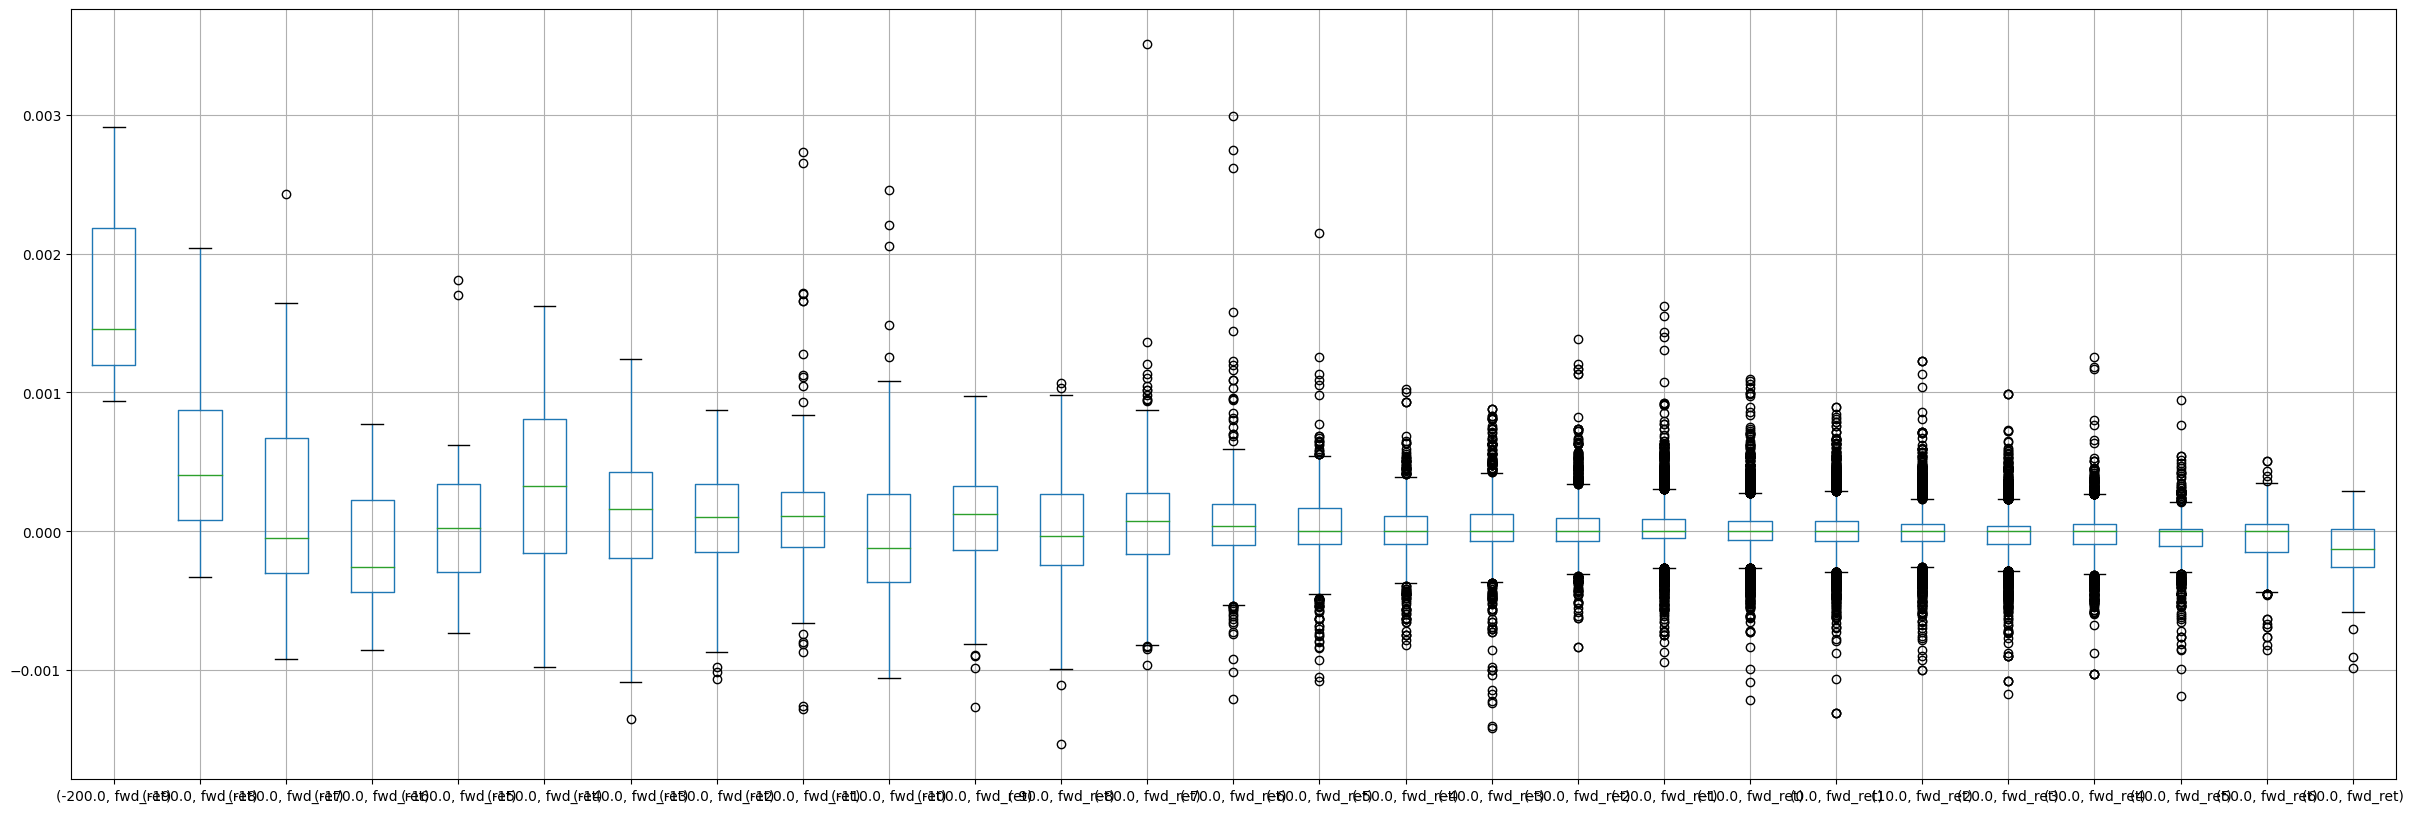

In [23]:
res.groupby('impl_dif')[['fwd_ret']].boxplot(subplots=False, figsize=(30, 10))

<Axes: >

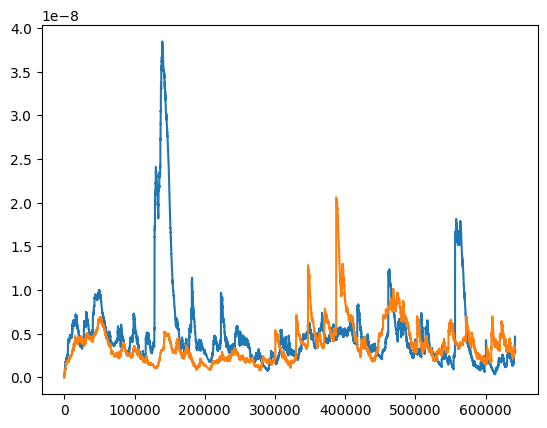

In [54]:
indicators.std_a.plot()
indicators.std_b.plot()

<Axes: >

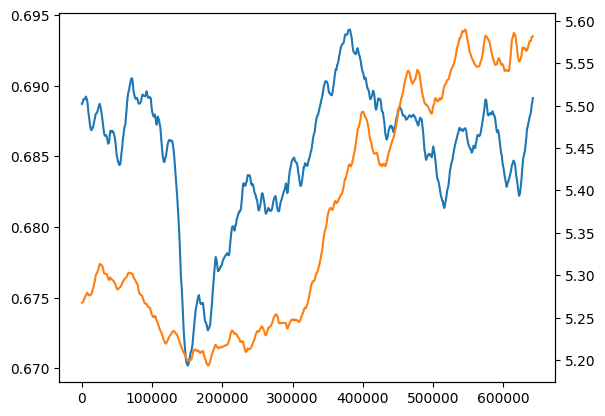

In [55]:
indicators.ema_a.plot()
indicators.ema_b.plot(secondary_y=True)

## Prepare Exchange

In [50]:
binance = TOB_Exchange(exchange_type = 'future')

In [51]:
usd_amount = 10_000
prices = quotes.groupby('symbol').ask_price.max()

per_asset = usd_amount // prices

In [52]:
for symbol in symbols: 
    binance.add_market(symbol, symbol[:-4], symbol[-4:])
    # binance.add_balance(symbol[:-4], per_asset[symbol])
    binance.add_balance(symbol[-4:], usd_amount)
    binance.load_tob(quotes.loc[quotes.symbol == symbol, ['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy(), symbol)
    binance.load_trades(trades.loc[trades.symbol == symbol, ['timestamp', 'id', 'side', 'price', 'amount']].to_numpy(), symbol)

2023-07-29 16:45:14,591 - INFO - src.exchange - Loading 284292 TOB-Updates for SUSHIUSDT
2023-07-29 16:45:16,816 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-29 16:45:16,871 - INFO - src.exchange - Loading 179322 trades for SUSHIUSDT
2023-07-29 16:45:17,186 - INFO - src.exchange - Trades loaded successfully
2023-07-29 16:45:17,275 - INFO - src.exchange - Loading 362406 TOB-Updates for UNIUSDT
2023-07-29 16:45:20,427 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-29 16:45:20,500 - INFO - src.exchange - Loading 297836 trades for UNIUSDT
2023-07-29 16:45:21,095 - INFO - src.exchange - Trades loaded successfully


## Spot Example

In [9]:
class strategy:
    def __init__(self, exchange, symbols, lookback_mean, lookback_var) -> None:

        # Amonut of USDT that will be traded
        self.volume = 1_000

        self.information = {}
        self.symbols = symbols
        self.exchange = exchange

        self.warmup = 5_000

        self.indicators = []

        for symbol in symbols: 
            self.information[symbol] = {}
            self.information[symbol]['ema'] = mean(lookback_mean)
            self.information[symbol]['var'] = var(lookback_var, calculate_ema=True)
            self.information[symbol]['price'] = None

        self.position = 0
            
    def trading_indicators(self):
        if self.information[self.symbols[1]]['var'].var == 0:
            vol_ratio = 0
        else:
            vol_ratio = self.information[self.symbols[0]]['var'].var / self.information[self.symbols[1]]['var'].var
        self.trend = 1 if vol_ratio > 1 else 0
        beta = self.information[self.symbols[0]]['ema'].ema / self.information[self.symbols[1]]['ema'].ema
        impl_mid = self.information[self.symbols[1]]['price'] * beta
        self.under = 1 if impl_mid < self.information[self.symbols[0]]['price'] else 0
        return [vol_ratio, beta, impl_mid, self.trend, self.under]

    def update_values(self, symbol: str, new_value: float, ts: float) -> list:
        change = new_value / self.information[symbol]['price'] - 1 if self.information[symbol]['price'] is not None else 0
        ema = self.information[symbol]['ema'].update(new_value, ts)
        var = self.information[symbol]['var'].update(change, ts)
        self.information[symbol]['price'] = new_value
        # self.indicators.append([ts, symbol, new_value, ema, var])
        return [new_value, ema, var]

    def decision(self, ts):
        if self.under and self.trend and self.position <= 0: 
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 1, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 0, ts)
            self.position += 1
        
        elif not self.under and not self.trend and self.position >= 0: 
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 0, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 1, ts)
            self.position -= 1



    def run_simulation(self):

        while len(self.exchange.events) > 0:
            self.exchange._simulation_step()

            ts = self.exchange.last_timestamp

            out = [ts]

            for symbol in self.symbols: 
                value = self.exchange.fetch_tob(symbol)
                mid = (value['ask_price'] + value['bid_price']) / 2
                out += self.update_values(symbol, mid, ts)
            
            out += self.trading_indicators()
            out += self.exchange.balances.values()

            self.indicators.append(out)
            if self.warmup < 0: 
                self.decision(ts)
            else: 
                self.warmup -= 1

In [10]:
strat = strategy(binance, symbols, 60 * 10 * 1_000_000, 60 * 10 * 1_000_000)

In [11]:
strat.run_simulation()

2023-07-29 13:29:50,114 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=477158, order_id=1, side=0, taker=True, amount=189.12529550827423, price=5.287, fees=0.19998108747044918, entryTime=1688170077624000.0, eventTime=1688170077627907.0)
2023-07-29 13:29:50,115 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=477159, order_id=0, side=1, taker=True, amount=1447.7017734346725, price=0.6908, fees=0.20001447701773434, entryTime=1688170077624000.0, eventTime=1688170077629493.5)
2023-07-29 13:29:50,359 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=477160, order_id=3, side=1, taker=True, amount=188.3771310162946, price=5.309, fees=0.20001883771310164, entryTime=1688171883825000.0, eventTime=1688171883829124.0)
2023-07-29 13:29:50,359 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=477161, order_id=2, side=0, taker=True, amount=1452.3273545857237, price=0.6885, fees=0.19998547672645417, entryTi

In [13]:
ind = pd.DataFrame(strat.indicators)

ind.columns = ['ts', 'price_a', 'ema_a', 'var_a', 'price_b', 'ema_b', 'var_b','vol_ratio', 'beta', 'impl_mid', 'trend', 'under', 'asset_a', 'quote', 'asset_b']
ind.ts = pd.to_datetime(ind.ts, unit='us')
ind.set_index('ts', inplace=True)
ind.sort_index(inplace=True)

ind['usd_a'] = ind['asset_a'] * ind['price_a']
ind['usd_b'] = ind['asset_b'] * ind['price_b']
ind['combined'] = ind.usd_a + ind.quote + ind.usd_b
ind['log_bal'] = np.log(ind.combined / ind.combined.shift())

In [55]:
strat_trades = pd.DataFrame(binance.trades)

strat_trades.index = pd.to_datetime(strat_trades.eventTime, unit='us')
trades_a = strat_trades[strat_trades.symbol == 'SUSHIUSDT']
trades_b = strat_trades[strat_trades.symbol == 'UNIUSDT']

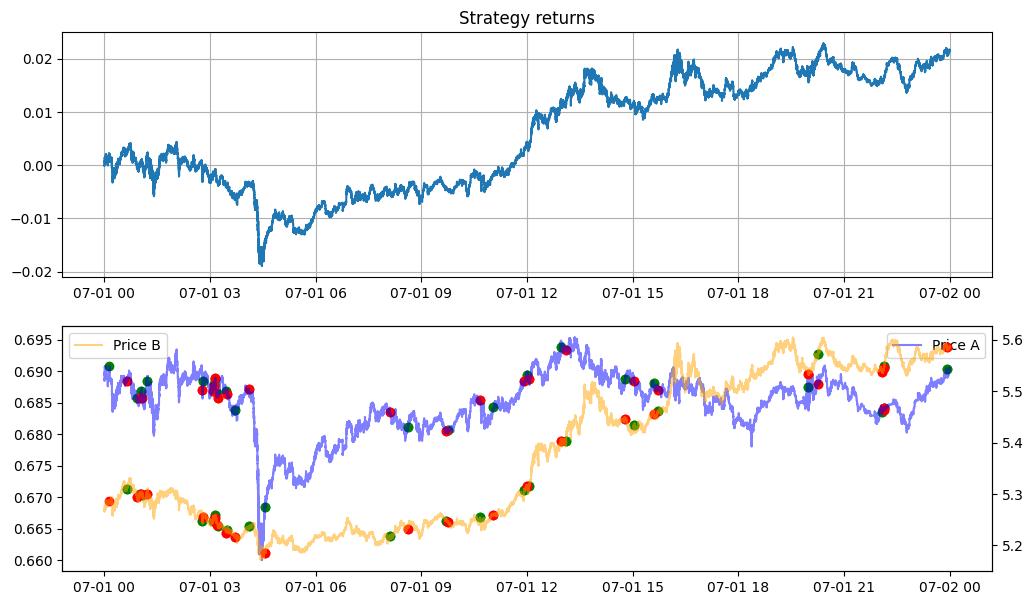

In [70]:
fig, axs = plt.subplots(2, figsize=(12, 7), facecolor='white')

ax1 = axs[0]
ax1.plot(ind.log_bal.cumsum(), label='change_midprice')

ax2 = axs[1]
ax22 = ax2.twinx()
ax2.plot(ind.price_a, label='Price A', color='blue', alpha=0.5)
ax2.scatter(trades_a[trades_a.side == 1].index, trades_a[trades_a.side == 1].price, color='green')
ax2.scatter(trades_a[trades_a.side == 0].index, trades_a[trades_a.side == 0].price, color='red')


ax22.plot(ind.price_b, label='Price B', color='orange', alpha=0.5)
ax22.scatter(trades_b[trades_b.side == 1].index, trades_b[trades_b.side == 1].price, color='green')
ax22.scatter(trades_b[trades_b.side == 0].index, trades_b[trades_b.side == 0].price, color='red')
ax2.legend()
ax22.legend()

ax1.set_title(f"Strategy returns")
ax1.grid()

## Futures Example

Here we make an example with only having USDT in our account and trading on a futures exchange. This means that were handling positions and only adjust the balances in USD.

The strategy itself is the same with a small adjustment where we expect a minimum distance in percent that the implied midprice must be off. 

In [53]:
class strategy:
    def __init__(self, exchange, symbols, lookback_mean, lookback_var) -> None:

        # Amonut of USDT that will be traded
        self.threshold = 0.004
        self.volume = 1_000

        self.information = {}
        self.symbols = symbols
        self.exchange = exchange

        self.warmup = 5_000

        self.opened = False

        self.indicators = []

        for symbol in symbols: 
            self.information[symbol] = {}
            self.information[symbol]['ema'] = mean(lookback_mean)
            self.information[symbol]['var'] = var(lookback_var, calculate_ema=True)
            self.information[symbol]['price'] = None

        self.position = 0
            
    def trading_indicators(self):
        if self.information[self.symbols[1]]['var'].var == 0:
            vol_ratio = 0
        else:
            vol_ratio = self.information[self.symbols[0]]['var'].var / self.information[self.symbols[1]]['var'].var
        self.trend = 1 if vol_ratio > 1 else 0
        beta = self.information[self.symbols[0]]['ema'].ema / self.information[self.symbols[1]]['ema'].ema
        impl_mid = self.information[self.symbols[1]]['price'] * beta
        self.ema_diff = impl_mid / self.information[self.symbols[0]]['price'] - 1
        return [vol_ratio, beta, impl_mid, self.trend, self.ema_diff]

    def update_values(self, symbol: str, new_value: float, ts: float) -> list:
        change = new_value / self.information[symbol]['price'] - 1 if self.information[symbol]['price'] is not None else 0
        ema = self.information[symbol]['ema'].update(new_value, ts)
        var = self.information[symbol]['var'].update(change, ts)
        self.information[symbol]['price'] = new_value
        # self.indicators.append([ts, symbol, new_value, ema, var])
        return [new_value, ema, var]

    def decision(self, ts):
        if self.ema_diff < -self.threshold and self.trend and self.position == 0: 
            print('enter long')
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 1, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 0, ts)
            self.position = 1

        elif self.ema_diff < 0 and self.position == -1 and abs(binance.positions[self.symbols[0]]) > 1: 
            print('close short')
            self.exchange.market_order(self.symbols[0], binance.positions[self.symbols[0]], 1, ts)
            self.exchange.market_order(self.symbols[1], binance.positions[self.symbols[1]], 0, ts)
            self.position = 0
        
        elif self.ema_diff > self.threshold and not self.trend and self.position == 0: 
            print('enter short')
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 0, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 1, ts)
            self.position = -1

        elif self.ema_diff > 0 and self.position == 1 and abs(binance.positions[self.symbols[0]]) > 1: 
            print('close long')
            self.exchange.market_order(self.symbols[0], binance.positions[self.symbols[0]], 0, ts)
            self.exchange.market_order(self.symbols[1], binance.positions[self.symbols[1]], 1, ts)
            self.position = 0

    def run_simulation(self):

        while len(self.exchange.events) > 0:
            self.exchange._simulation_step()

            ts = self.exchange.last_timestamp

            out = [ts]

            for symbol in self.symbols: 
                value = self.exchange.fetch_tob(symbol)
                mid = (value['ask_price'] + value['bid_price']) / 2
                out += self.update_values(symbol, mid, ts)
            
            out += self.trading_indicators()
            out += self.exchange.balances.values()
            out += self.exchange.positions.values()

            self.indicators.append(out)
            if self.warmup < 0: 
                self.decision(ts)
            else: 
                self.warmup -= 1

In [54]:
strat = strategy(binance, symbols, 60 * 10 * 1_000_000, 60 * 10 * 1_000_000)
strat.run_simulation()

2023-07-29 16:45:22,133 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433761, order_id=95471, side=0, taker=True, amount=188.80392712168413, price=5.296, fees=0.19998111960728784, entryTime=1688176019020000.0, eventTime=1688176019025046.5)
2023-07-29 16:45:22,134 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433762, order_id=95470, side=1, taker=True, amount=1448.8554042306578, price=0.6903, fees=0.20002897710808462, entryTime=1688176019020000.0, eventTime=1688176019025892.5)
2023-07-29 16:45:22,181 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433763, order_id=95472, side=0, taker=True, amount=1448.8554042306578, price=0.6898, fees=0.19988409156766154, entryTime=1688176425331000.0, eventTime=1688176425338005.8)
2023-07-29 16:45:22,182 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433764, order_id=95473, side=1, taker=True, amount=188.80392712168413, price=5.307, fees=0.20039

enter long
close long
enter long
close long


2023-07-29 16:45:22,466 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433769, order_id=95478, side=1, taker=True, amount=1447.1780028943558, price=0.6911, fees=0.2000289435600579, entryTime=1688178684555000.0, eventTime=1688178684557908.2)
2023-07-29 16:45:22,467 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433770, order_id=95479, side=0, taker=True, amount=189.7353192296746, price=5.27, fees=0.199981026468077, entryTime=1688178684555000.0, eventTime=1688178684560360.8)
2023-07-29 16:45:22,578 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433771, order_id=95481, side=1, taker=True, amount=189.7353192296746, price=5.247, fees=0.19910824399962052, entryTime=1688179612212000.0, eventTime=1688179612217180.2)
2023-07-29 16:45:22,578 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433772, order_id=95480, side=0, taker=True, amount=1447.1780028943558, price=0.687, fees=0.198842257597

enter long
close long


2023-07-29 16:45:23,747 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433773, order_id=95482, side=1, taker=True, amount=1478.524432616249, price=0.6764, fees=0.20001478524432617, entryTime=1688187381900000.0, eventTime=1688187381903596.5)
2023-07-29 16:45:23,751 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433774, order_id=95483, side=0, taker=True, amount=191.92016121293543, price=5.21, fees=0.1999808079838787, entryTime=1688187381900000.0, eventTime=1688187381905329.0)
2023-07-29 16:45:23,834 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433775, order_id=95484, side=0, taker=True, amount=1478.524432616249, price=0.674, fees=0.1993050935166704, entryTime=1688188080190000.0, eventTime=1688188080193744.0)
2023-07-29 16:45:23,834 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433776, order_id=95485, side=1, taker=True, amount=191.92016121293543, price=5.203, fees=0.19971211975

enter long
close long


2023-07-29 16:45:24,647 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433777, order_id=95486, side=1, taker=True, amount=1460.1737606775207, price=0.6849, fees=0.20001460173760677, entryTime=1688196834405000.0, eventTime=1688196834409583.8)
2023-07-29 16:45:24,648 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433778, order_id=95487, side=0, taker=True, amount=191.40587616039812, price=5.224, fees=0.19998085941238397, entryTime=1688196834405000.0, eventTime=1688196834414530.2)
2023-07-29 16:45:24,745 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433779, order_id=95488, side=0, taker=True, amount=1460.1737606775207, price=0.683, fees=0.19945973570854936, entryTime=1688198069732000.0, eventTime=1688198069737343.8)
2023-07-29 16:45:24,745 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433780, order_id=95489, side=1, taker=True, amount=191.40587616039812, price=5.21, fees=0.1994449

enter long
close long


2023-07-29 16:45:26,192 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433781, order_id=95491, side=1, taker=True, amount=186.89842070834501, price=5.351, fees=0.20001868984207083, entryTime=1688213256473000.0, eventTime=1688213256478242.5)
2023-07-29 16:45:26,192 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433782, order_id=95490, side=0, taker=True, amount=1448.3307987544356, price=0.6904, fees=0.19998551669201248, entryTime=1688213256473000.0, eventTime=1688213256480850.8)
2023-07-29 16:45:26,381 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433783, order_id=95492, side=1, taker=True, amount=1448.3307987544356, price=0.6911, fees=0.2001882830038381, entryTime=1688213936988000.0, eventTime=1688213936994588.0)
2023-07-29 16:45:26,382 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433784, order_id=95493, side=0, taker=True, amount=186.89842070834501, price=5.359, fees=0.200317

enter short
close short
enter short


2023-07-29 16:45:26,396 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433785, order_id=95495, side=1, taker=True, amount=185.58040270947387, price=5.394, fees=0.20020413844298043, entryTime=1688213958683000.0, eventTime=1688213958687064.0)
2023-07-29 16:45:26,397 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433786, order_id=95494, side=0, taker=True, amount=1450.2211587267059, price=0.6895, fees=0.19998549778841276, entryTime=1688213958683000.0, eventTime=1688213958687900.0)
2023-07-29 16:45:26,544 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433787, order_id=95496, side=1, taker=True, amount=1450.2211587267059, price=0.6888, fees=0.199782466826191, entryTime=1688214769734000.0, eventTime=1688214769739487.0)
2023-07-29 16:45:26,544 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433788, order_id=95497, side=0, taker=True, amount=185.58040270947387, price=5.374, fees=0.1994618

close short


2023-07-29 16:45:26,816 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433789, order_id=95499, side=1, taker=True, amount=184.4167819271554, price=5.423, fees=0.20001844167819274, entryTime=1688216810681000.0, eventTime=1688216810686658.5)
2023-07-29 16:45:26,816 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433790, order_id=95498, side=0, taker=True, amount=1442.273022283118, price=0.6933, fees=0.19998557726977717, entryTime=1688216810681000.0, eventTime=1688216810688603.5)
2023-07-29 16:45:26,998 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433791, order_id=95501, side=0, taker=True, amount=184.4167819271554, price=5.437, fees=0.2005348086675888, entryTime=1688217901029000.0, eventTime=1688217901031909.8)
2023-07-29 16:45:26,998 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433792, order_id=95500, side=1, taker=True, amount=1442.273022283118, price=0.6952, fees=0.2005336410

enter short
close short


2023-07-29 16:45:27,044 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433793, order_id=95502, side=0, taker=True, amount=1446.0270407056612, price=0.6915, fees=0.19998553972959296, entryTime=1688218204887000.0, eventTime=1688218204892161.0)
2023-07-29 16:45:27,044 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433794, order_id=95503, side=1, taker=True, amount=184.00956849756187, price=5.435, fees=0.20001840095684975, entryTime=1688218204887000.0, eventTime=1688218204894243.0)


enter short


2023-07-29 16:45:27,355 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433795, order_id=95505, side=0, taker=True, amount=184.00956849756187, price=5.49, fees=0.20204250621032296, entryTime=1688219970294000.0, eventTime=1688219970297979.2)
2023-07-29 16:45:27,355 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433796, order_id=95504, side=1, taker=True, amount=1446.0270407056612, price=0.6909, fees=0.19981201648470828, entryTime=1688219970294000.0, eventTime=1688219970299090.2)


close short


2023-07-29 16:45:27,727 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433797, order_id=95506, side=1, taker=True, amount=1449.380389883325, price=0.69, fees=0.20001449380389885, entryTime=1688223087467000.0, eventTime=1688223087469769.0)
2023-07-29 16:45:27,727 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433798, order_id=95507, side=0, taker=True, amount=184.14510634379891, price=5.43, fees=0.19998158548936562, entryTime=1688223087467000.0, eventTime=1688223087470185.5)
2023-07-29 16:45:27,783 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433799, order_id=95509, side=1, taker=True, amount=184.14510634379891, price=5.428, fees=0.19990792744682812, entryTime=1688223675222000.0, eventTime=1688223675225441.5)
2023-07-29 16:45:27,784 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433800, order_id=95508, side=0, taker=True, amount=1449.380389883325, price=0.6886, fees=0.1996086672

enter long
close long


2023-07-29 16:45:28,140 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433801, order_id=95510, side=0, taker=True, amount=1450.2211587267059, price=0.6895, fees=0.19998549778841276, entryTime=1688227533066000.0, eventTime=1688227533073130.2)
2023-07-29 16:45:28,141 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433802, order_id=95511, side=1, taker=True, amount=181.17583114412537, price=5.52, fees=0.2000181175831144, entryTime=1688227533066000.0, eventTime=1688227533075794.2)


enter short


2023-07-29 16:45:28,559 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433803, order_id=95512, side=1, taker=True, amount=1450.2211587267059, price=0.6885, fees=0.1996954535566674, entryTime=1688228537361000.0, eventTime=1688228537365078.2)
2023-07-29 16:45:28,560 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433804, order_id=95513, side=0, taker=True, amount=181.17583114412537, price=5.544, fees=0.2008877615726062, entryTime=1688228537361000.0, eventTime=1688228537365658.0)


close short


2023-07-29 16:45:28,776 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433805, order_id=95515, side=1, taker=True, amount=180.19641409135957, price=5.55, fees=0.2000180196414091, entryTime=1688229611762000.0, eventTime=1688229611767196.5)
2023-07-29 16:45:28,776 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433806, order_id=95514, side=0, taker=True, amount=1455.2863275849522, price=0.6871, fees=0.19998544713672417, entryTime=1688229611762000.0, eventTime=1688229611768622.8)
2023-07-29 16:45:28,831 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433807, order_id=95516, side=1, taker=True, amount=1455.2863275849522, price=0.687, fees=0.19995634141017246, entryTime=1688229964037000.0, eventTime=1688229964042929.2)
2023-07-29 16:45:28,832 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433808, order_id=95517, side=0, taker=True, amount=180.19641409135957, price=5.538, fees=0.19958554

enter short
close short


2023-07-29 16:45:29,208 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433809, order_id=95518, side=0, taker=True, amount=1460.8136732159812, price=0.6845, fees=0.19998539186326783, entryTime=1688233619667000.0, eventTime=1688233619670028.2)
2023-07-29 16:45:29,209 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433810, order_id=95519, side=1, taker=True, amount=181.24150430448572, price=5.518, fees=0.20001812415043044, entryTime=1688233619667000.0, eventTime=1688233619671881.2)
2023-07-29 16:45:29,348 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433811, order_id=95521, side=0, taker=True, amount=181.24150430448572, price=5.497, fees=0.1992569098323516, entryTime=1688234943524000.0, eventTime=1688234943529875.5)
2023-07-29 16:45:29,349 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433812, order_id=95520, side=1, taker=True, amount=1460.8136732159812, price=0.6813, fees=0.199050

enter short
close short


2023-07-29 16:45:29,418 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433813, order_id=95522, side=0, taker=True, amount=1468.5366032748368, price=0.6809, fees=0.19998531463396726, entryTime=1688235609758000.0, eventTime=1688235609760799.8)
2023-07-29 16:45:29,418 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433814, order_id=95523, side=1, taker=True, amount=180.91361374943466, price=5.528, fees=0.20001809136137497, entryTime=1688235609758000.0, eventTime=1688235609763280.8)
2023-07-29 16:45:29,468 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433815, order_id=95524, side=1, taker=True, amount=1468.5366032748368, price=0.6818, fees=0.20024965122255675, entryTime=1688235965349000.0, eventTime=1688235965353259.2)
2023-07-29 16:45:29,469 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433816, order_id=95525, side=0, taker=True, amount=180.91361374943466, price=5.526, fees=0.19994

enter short
close short


2023-07-29 16:45:29,700 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433817, order_id=95527, side=1, taker=True, amount=178.77893984088672, price=5.594, fees=0.20001787789398406, entryTime=1688238274536000.0, eventTime=1688238274540007.8)
2023-07-29 16:45:29,700 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433818, order_id=95526, side=0, taker=True, amount=1455.0745725718443, price=0.6872, fees=0.1999854492542743, entryTime=1688238274536000.0, eventTime=1688238274541085.5)
2023-07-29 16:45:29,729 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433819, order_id=95528, side=1, taker=True, amount=1455.0745725718443, price=0.6875, fees=0.2000727537286286, entryTime=1688238502198000.0, eventTime=1688238502200792.5)
2023-07-29 16:45:29,730 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433820, order_id=95529, side=0, taker=True, amount=178.77893984088672, price=5.576, fees=0.1993742

enter short
close short


2023-07-29 16:45:30,095 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433821, order_id=95530, side=1, taker=True, amount=1454.6512473634446, price=0.6875, fees=0.20001454651247363, entryTime=1688241511052000.0, eventTime=1688241511057242.8)
2023-07-29 16:45:30,095 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433822, order_id=95531, side=0, taker=True, amount=180.68479537446925, price=5.534, fees=0.19998193152046256, entryTime=1688241511052000.0, eventTime=1688241511057530.5)
2023-07-29 16:45:30,114 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433823, order_id=95533, side=1, taker=True, amount=180.68479537446925, price=5.537, fees=0.20009034239768725, entryTime=1688241556205000.0, eventTime=1688241556208139.0)
2023-07-29 16:45:30,114 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433824, order_id=95532, side=0, taker=True, amount=1454.6512473634446, price=0.6838, fees=0.19893

enter long
close long
enter long
close long


2023-07-29 16:45:30,951 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433829, order_id=95538, side=0, taker=True, amount=1462.3089858887183, price=0.6838, fees=0.19998537691014112, entryTime=1688249394749000.0, eventTime=1688249394753555.2)
2023-07-29 16:45:30,952 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433830, order_id=95539, side=1, taker=True, amount=179.54933117874137, price=5.571, fees=0.20005386479935364, entryTime=1688249394749000.0, eventTime=1688249394754718.0)
2023-07-29 16:45:31,065 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=2433831, order_id=95541, side=0, taker=True, amount=179.54933117874137, price=5.578, fees=0.2003052338630039, entryTime=1688250713857000.0, eventTime=1688250713860217.2)
2023-07-29 16:45:31,065 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=2433832, order_id=95540, side=1, taker=True, amount=1462.3089858887183, price=0.6839, fees=0.200014

enter short
close short


In [55]:
ind = pd.DataFrame(strat.indicators)

ind.columns = ['ts', 'price_a', 'ema_a', 'var_a', 'price_b', 'ema_b', 'var_b','vol_ratio', 'beta', 'impl_mid', 'trend', 'under', 'quote', 'position_a', 'position_b']
ind.ts = pd.to_datetime(ind.ts, unit='us')
ind.set_index('ts', inplace=True)
ind.sort_index(inplace=True)

ind['usd_a'] = ind.price_a * ind.position_a
ind['usd_b'] = ind.price_b * ind.position_b

In [56]:
strat_trades = pd.DataFrame(binance.trades)

strat_trades.index = pd.to_datetime(strat_trades.eventTime, unit='us')
trades_a = strat_trades[strat_trades.symbol == 'SUSHIUSDT']
trades_b = strat_trades[strat_trades.symbol == 'UNIUSDT']

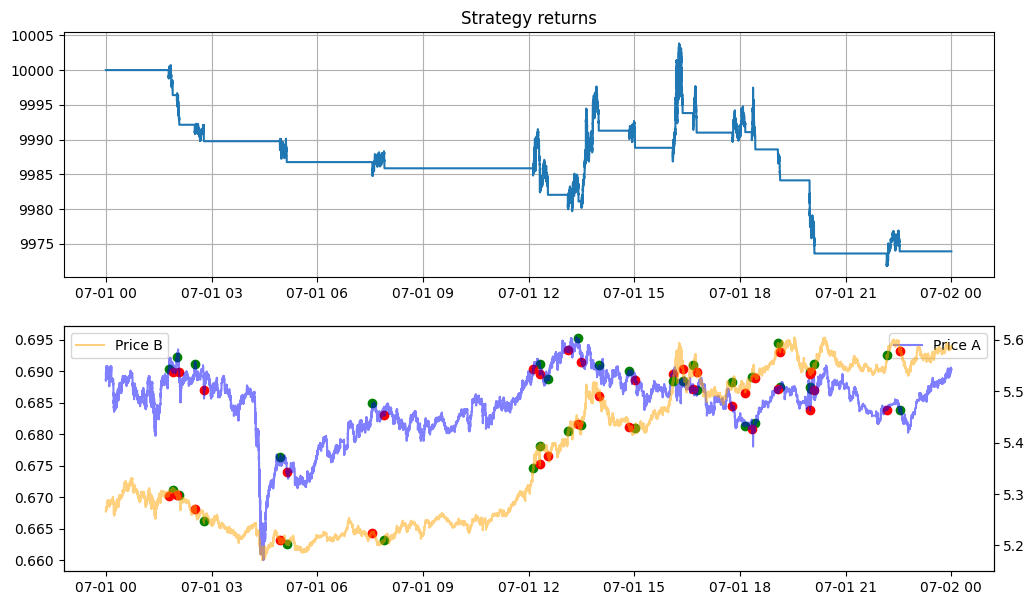

In [57]:
fig, axs = plt.subplots(2, figsize=(12, 7), facecolor='white')

ax1 = axs[0]
ax1.plot(ind.quote + ind.usd_a + ind.usd_b, label='Quote Balance')

ax2 = axs[1]
ax22 = ax2.twinx()
ax2.plot(ind.price_a, label='Price A', color='blue', alpha=0.5)
ax2.scatter(trades_a[trades_a.side == 1].index, trades_a[trades_a.side == 1].price, color='green')
ax2.scatter(trades_a[trades_a.side == 0].index, trades_a[trades_a.side == 0].price, color='red')


ax22.plot(ind.price_b, label='Price B', color='orange', alpha=0.5)
ax22.scatter(trades_b[trades_b.side == 1].index, trades_b[trades_b.side == 1].price, color='green')
ax22.scatter(trades_b[trades_b.side == 0].index, trades_b[trades_b.side == 0].price, color='red')
ax2.legend()
ax22.legend()

ax1.set_title(f"Strategy returns")
ax1.grid()